In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math 

import jlinops

from jlinops import get_device

# Proximal operator for L1 norm

In [7]:
def prox_l1_norm(x, lam=1.0):
    """Evaluates prox_f(x) where f(x) = lam*||x||_1.
    This is the soft thresholding function T_lam(x).
    """
    device = get_device(x)
    if device == "cpu":
        return np.sign(x) * np.maximum(np.abs(x) - lam, 0)
    else:
        return cp.sign(x) * cp.maximum(np.abs(x) - lam, 0)

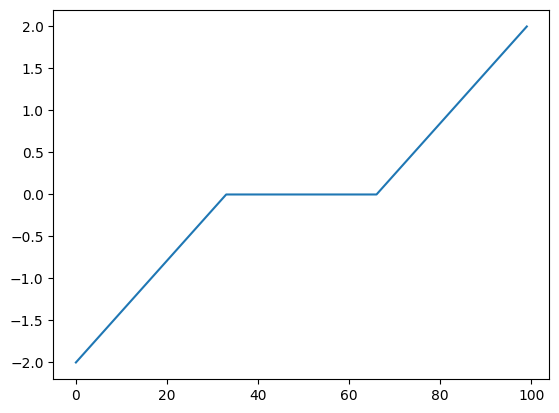

In [13]:
plt.plot(prox_l1_norm(np.linspace(-3, 3, 100)))
plt.show()

# Proximal operator for 1D total variation norm

In [11]:
# prox_tv1d_norm
"""Evaluates prox_f (x) where f(x) = lam*|| TV(x) ||_1,
with TV a 1D discrete-gradient matrix.

Equivalent to the solution of

min_u  (1/2)*|| u - x ||_2^2 + lam*|| TV(x) ||_1.

"""

'Evaluates prox_f (x) where f(x) = lam*|| TV(x) ||_1,\nwith TV a 1D discrete-gradient matrix.\n\nEquivalent to the solution of\n\nmin_u  (1/2) | u - x ||_2^2 + lam*|| ||\n\n'

In [85]:
def prox_tv1d_norm(x, lam=1.0, method="dpg", boundary="none", initialization=None, return_data=False, iterations=20):
    """Evaluates prox_f (x) where f(x) = lam*|| TV(x) ||_1,
    with TV a 1D discrete-gradient matrix.

    Equivalent to the solution of

    min_v  (1/2)*|| v - x ||_2^2 + lam*|| TV(v) ||_1.

    """

    assert method in ["dpg", "fdpg"], "invalid method"
    
    # Build derivative matrix
    n = len(x)
    D, _ = jlinops.first_order_derivative_1d(n, boundary=boundary) 
    Dt = D.T

    # Objective function
    obj_fn = lambda v: 0.5*(np.linalg.norm(v - x)**2) + lam*np.abs(D @ v).sum()

    # Other
    L = 4

    if method == "dpg":
        
        # Initialize y
        if initialization is None:
            y = np.zeros(D.shape[0])
        else:
            y = initialization
        obj_vals = []

        # Iterations
        for j in range(iterations):
            v = (Dt @ y) + x
            Dv = D @ v
            y = y - (1/L)*(Dv) + (1/L)*prox_l1_norm(Dv - L*y, lam=4*lam)
            obj_vals.append(obj_fn(v))

        if return_data:
            solver_data = {
                "result": v,
                "obj_vals": np.asarray(obj_vals),
            }
            return v, solver_data
        else:
            return v

    elif method == "fdpg":

        # Initialize
        if initialization is None:
            y_prev = np.zeros(D.shape[0])
        else:
            y_prev = initialization
        w = y_prev.copy()
        t_prev = 1
        obj_vals = []

        # Iterations
        for j in range(iterations):
            u = (Dt @ w) + x
            Du = D @ u
            y_curr = w - (1/L)*Du + (1/L)*prox_l1_norm( Du - L*w, lam=L*lam)
            t_curr = 0.5*(1 + np.sqrt(1 + L*(t_prev**2)))
            w = y_curr + ((t_prev-1)/t_curr)*(y_curr - y_prev)

            # Advance
            y_prev = y_curr
            t_prev = t_curr
            
            v = (Dt @ y_curr) + x
            obj_vals.append(obj_fn(v))

        if return_data:
            solver_data = {
                "result": v,
                "obj_vals": np.asarray(obj_vals),
            }
            return v, solver_data
        else:
            return v

    else:
        raise NotImplementedError
    



# Example problem

In [58]:
ground_truth = jlinops.piecewise_constant_1d_test_problem()
np.random.seed(0)
noise_stdev = 0.05
noisy_signal = ground_truth + noise_stdev*np.random.normal(size=len(ground_truth))

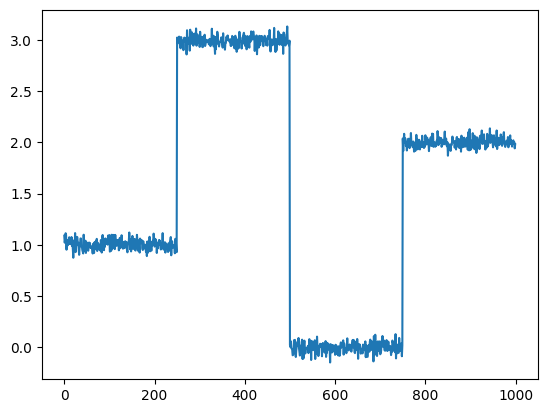

In [59]:
plt.plot(noisy_signal)
plt.show()

In [83]:
# Compare both methods
_, data_dpg = prox_tv1d_norm(noisy_signal, lam=1e1, iterations=100, return_data=True, method="dpg")
_, data_fdpg = prox_tv1d_norm(noisy_signal, lam=1e1, iterations=1000, return_data=True, method="fdpg")

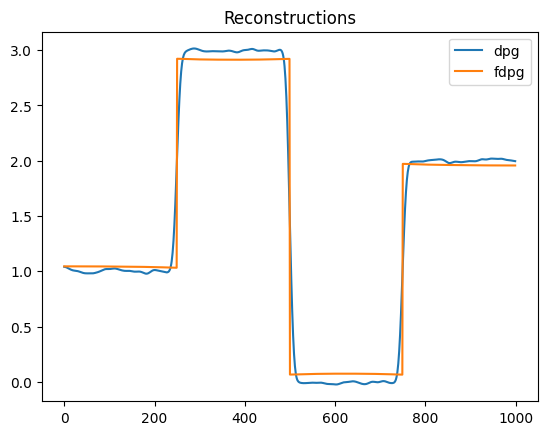

In [84]:
plt.plot(data_dpg["result"], label="dpg")
plt.plot(data_fdpg["result"], label="fdpg")
plt.title("Reconstructions")
plt.legend()
plt.show()

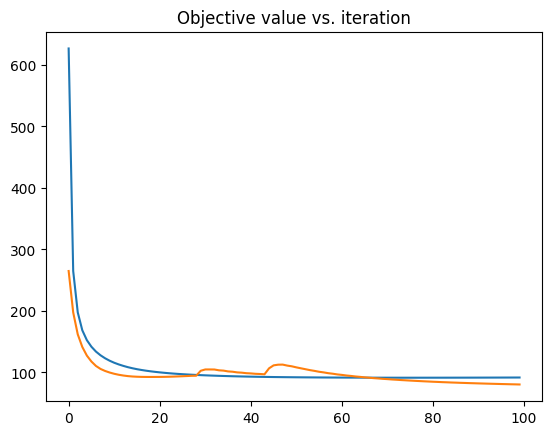

In [80]:
plt.plot(data_dpg["obj_vals"])
plt.plot(data_fdpg["obj_vals"])
plt.title("Objective value vs. iteration")
plt.show()

In [75]:
# Compare both methods
_, data_dpg = prox_tv1d_norm(noisy_signal, lam=1e1, iterations=100000, return_data=True, method="dpg")
_, data_fdpg = prox_tv1d_norm(noisy_signal, lam=1e1, iterations=1000, return_data=True, method="fdpg")

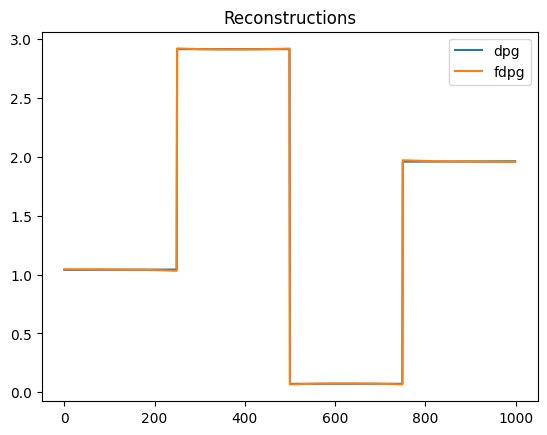

In [76]:
plt.plot(data_dpg["result"], label="dpg")
plt.plot(data_fdpg["result"], label="fdpg")
plt.title("Reconstructions")
plt.legend()
plt.show()

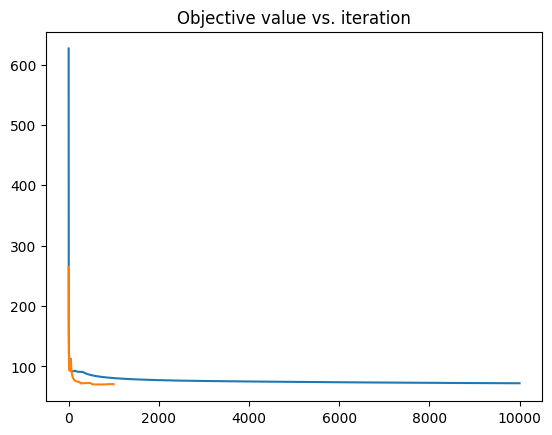

In [74]:
plt.plot(data_dpg["obj_vals"])
plt.plot(data_fdpg["obj_vals"])
plt.title("Objective value vs. iteration")
plt.show()

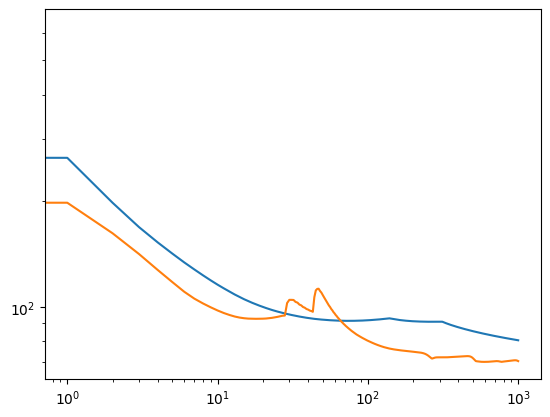

In [66]:
plt.loglog(data_dpg["obj_vals"])
plt.loglog(data_fdpg["obj_vals"])
plt.show()

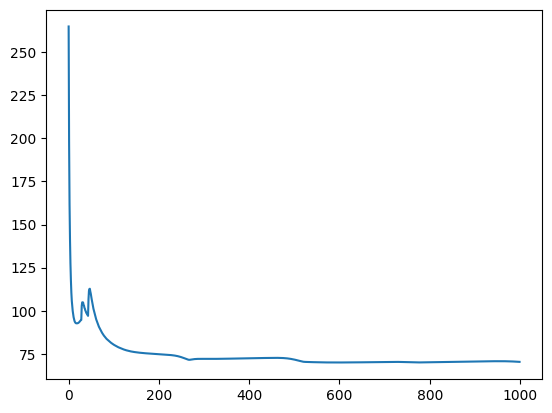

In [63]:
plt.plot(data["obj_vals"])
plt.show()

In [40]:
# Check O(1/k) convergence?
_, data = prox_tv1d_norm(noisy_signal, lam=1e1, iterations=1000, return_data=True)
# opt_val = data["obj_vals"][-1]
# errs = np.abs(data["obj_vals"][:-1] - opt_val)

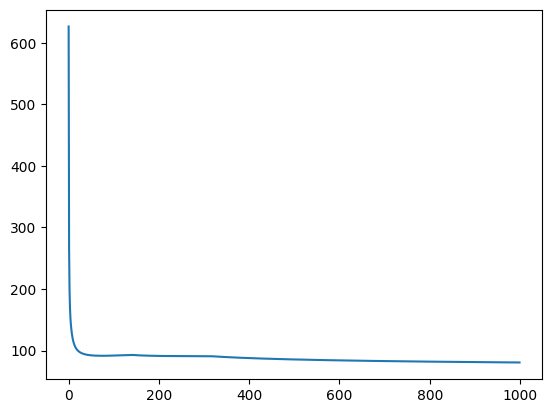

In [41]:
plt.plot(data["obj_vals"])
plt.show()

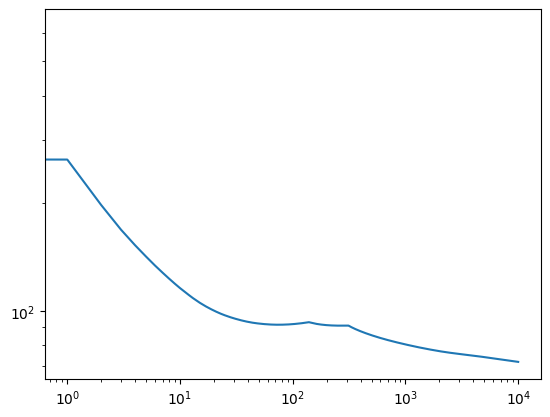

In [29]:
plt.loglog(data["obj_vals"])
plt.show()

# 2D

In [87]:
def prox_tv2d_anisotropic_norm(x, grid_shape=None, lam=1.0, method="dpg", boundary="none", initialization=None, return_data=False, iterations=20):
    """Evaluates prox_f (x) where f(x) = lam*|| TV(x) ||_1,
    with TV a 2D discrete-gradient matrix.

    Equivalent to the solution of

    min_v  (1/2)*|| v - x ||_2^2 + lam*|| TV(v) ||_1.

    """

    assert method in ["dpg", "fdpg"], "invalid method"
    assert grid_shape is not None, "must provide a grid shape"
    n = math.prod(grid_shape)
    assert len(x) == n, "grid_shape and input vector incompatible"
    
    # Build derivative matrix
    n = len(x)
    D, _ = jlinops.first_order_derivative_2d(grid_shape, boundary=boundary)
    Dt = D.T

    # Objective function
    obj_fn = lambda v: 0.5*(np.linalg.norm(v - x)**2) + lam*np.abs(D @ v).sum()

    # Other
    L = 8

    if method == "dpg":
        
        # Initialize y
        if initialization is None:
            y = np.zeros(D.shape[0])
        else:
            y = initialization
        obj_vals = []

        # Iterations
        for j in range(iterations):
            v = (Dt @ y) + x
            Dv = D @ v
            y = y - (1/L)*(Dv) + (1/L)*prox_l1_norm(Dv - L*y, lam=4*lam)
            obj_vals.append(obj_fn(v))

        if return_data:
            solver_data = {
                "result": v,
                "obj_vals": np.asarray(obj_vals),
            }
            return v, solver_data
        else:
            return v

    elif method == "fdpg":

        # Initialize
        if initialization is None:
            y_prev = np.zeros(D.shape[0])
        else:
            y_prev = initialization
        w = y_prev.copy()
        t_prev = 1
        obj_vals = []

        # Iterations
        for j in range(iterations):
            u = (Dt @ w) + x
            Du = D @ u
            y_curr = w - (1/L)*Du + (1/L)*prox_l1_norm( Du - L*w, lam=L*lam)
            t_curr = 0.5*(1 + np.sqrt(1 + L*(t_prev**2)))
            w = y_curr + ((t_prev-1)/t_curr)*(y_curr - y_prev)

            # Advance
            y_prev = y_curr
            t_prev = t_curr
            
            v = (Dt @ y_curr) + x
            obj_vals.append(obj_fn(v))

        if return_data:
            solver_data = {
                "result": v,
                "obj_vals": np.asarray(obj_vals),
            }
            return v, solver_data
        else:
            return v

    else:
        raise NotImplementedError
    



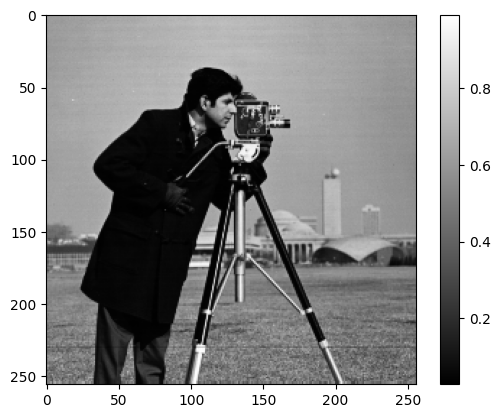

In [96]:
ground_truth = jlinops.cameraman()

plt.imshow(ground_truth, cmap="gray")
plt.colorbar()
plt.show()

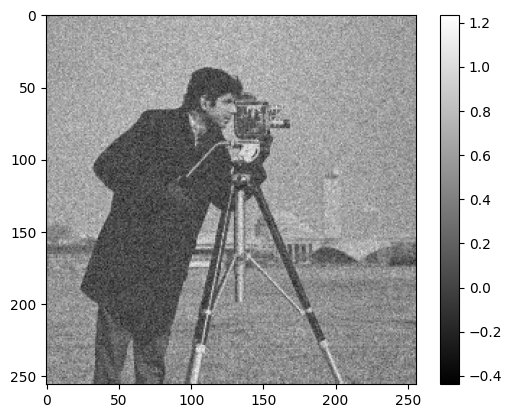

In [97]:
np.random.seed(0)
noise_stdev = 0.1
noisy_signal = ground_truth + noise_stdev*np.random.normal(size=ground_truth.shape)

plt.imshow(noisy_signal, cmap="gray")
plt.colorbar()
plt.show()

In [139]:
_, data = prox_tv2d_anisotropic_norm(noisy_signal.flatten(), lam=1e-1, method="fdpg", grid_shape=ground_truth.shape, iterations=100, return_data=True, boundary="none")

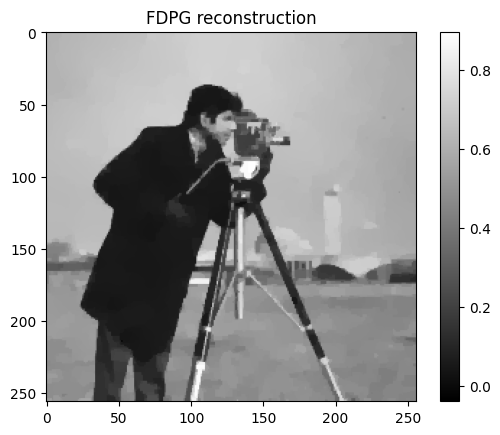

In [140]:
plt.imshow(data["result"].reshape(ground_truth.shape), cmap="gray")
plt.title("FDPG reconstruction")
plt.colorbar()
plt.show()

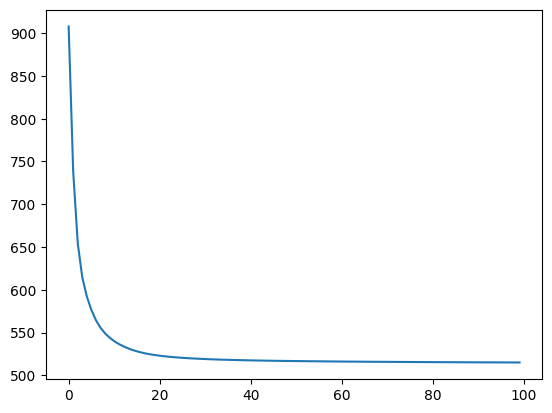

In [141]:
plt.plot(data["obj_vals"])
plt.show()